# Pretrained MNIST Models
Yao Fehlis

This example covers the basic features of the loss-landscapes library, i.e. evaluating a model's loss function along lines or planes in parameter space in order to produce visualizations of the loss landscape.

I combined some features from the notebooks https://github.com/marcellodebernardi/loss-landscapes/blob/master/examples/core-features.ipynb and Ashley Dale's alignn_pretrained.ipynb.

In [1]:
!git clone https://github.com/marcellodebernardi/loss-landscapes.git

fatal: destination path 'loss-landscapes' already exists and is not an empty directory.


In [2]:
!mv loss-landscapes/loss_landscapes/ .

mv: cannot stat 'loss-landscapes/loss_landscapes/': No such file or directory


In [10]:
%matplotlib widget

In [33]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from torchinfo import summary

import loss_landscapes
import loss_landscapes.metrics

from loss_landscapes.model_interface.model_wrapper import ModelWrapper
import torch
import torch.nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

import os

### 1. Preliminary: Classifying MNIST


This notebook demonstrates how to accomplish a simple task: visualizing the loss landscape of a small fully connected feed-forward neural network on the MNIST image classification task. In this section the preliminaries (the model and the training procedure) are setup.

In [15]:
# training hyperparameters
IN_DIM = 28 * 28
OUT_DIM = 10
LR = 10 ** -2
BATCH_SIZE = 512
EPOCHS = 25
# contour plot resolution
STEPS = 40

The cells in this section contain no code specific to the loss-landscapes library.

In [16]:
class MLPSmall(torch.nn.Module):
    """ Fully connected feed-forward neural network with one hidden layer. """
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(x_dim, 32)
        self.linear_2 = torch.nn.Linear(32, y_dim)

    def forward(self, x):
        h = F.relu(self.linear_1(x))
        return F.softmax(self.linear_2(h), dim=1)


class Flatten(object):
    """ Transforms a PIL image to a flat numpy array. """
    def __call__(self, sample):
        return np.array(sample, dtype=np.float32).flatten()    
    

def train(model, optimizer, criterion, train_loader, epochs):
    """ Trains the given model with the given optimizer, loss function, etc. """
    model.train()
    # train model
    for _ in tqdm(range(epochs), 'Training'):
        for count, batch in enumerate(train_loader, 0):
            optimizer.zero_grad()
            x, y = batch

            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

    model.eval()

We then create the model and an instance of the MNIST dataset.

In [19]:
# download MNIST and setup data loaders
mnist_train = datasets.MNIST(root='../data', train=True, download=True, transform=Flatten())
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=False)

# define model
model = MLPSmall(IN_DIM, OUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

### 2. Points in Parameter Space

The state of a neural network model represents a point in parameter space. Several functions in the loss-landscapes library require the user to provide instances of neural network models as arguments, where the model is taken to represent the point in parameter space corresponding to its parameters' state. Representing points as simply the models they relate to reduces the complexity of the client code.

In the cell below, a copy of the model before training is made, to preserve the model's initial state.

In [20]:
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)

Two common points of interest are the model initialization, and the model's final parameters after training. Similarly to the cell above, we can make a copy of the model after training. A copy of the model can be made at any time - this is up to the user, of course.

In [23]:
train(model, optimizer, criterion, train_loader, EPOCHS)

model_final = copy.deepcopy(model)

Training: 100%|██████████| 25/25 [00:55<00:00,  2.23s/it]


In [35]:
# Get all the model parameters
params = [p for p in model.parameters()]

# Calculate the standard deviation of all parameters
wt_std = torch.std(torch.cat([p.view(-1) for p in params]))

DISTANCE=10*wt_std.detach().numpy()

print(DISTANCE)

2.7418383955955505


### 3. Linear Interpolations of Loss between Two Points

In the previous section, copies of the model before and after training were obtained. A common use case is to evaluate the model loss at a number of equidistant points along the straight line connecting the two points. Although care must be taken in interpreting such plots, the idea is to gain an insight into the smoothness of the landscape.

The user might also be interested in collecting any other quantity along this line. The loss-landscapes library abstracts these details with entities called Metrics, which compute some quantity about a model for its current parameters. A number of pre-defined metrics is provided in the loss_landscapes.metrics package, and the user is free to write custom metrics. See the relevant documentation.

An important metric is Loss, which applies a PyTorch loss function to a PyTorch model and returns the value produced.

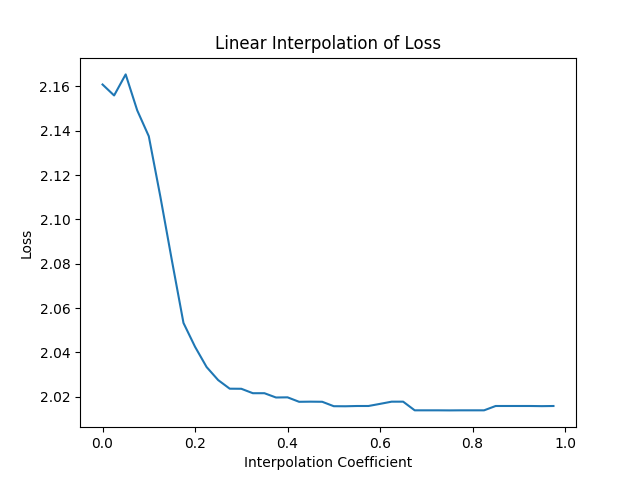

In [26]:
# data that the evaluator will use when evaluating loss
x, y = iter(train_loader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x, y)

# compute loss data
loss_data = loss_landscapes.linear_interpolation(model_initial, model_final, metric, STEPS, deepcopy_model=True)

#With the computed loss data, a linear interpolation plot can be rendered.

plt.plot([1/STEPS * i for i in range(STEPS)], loss_data)
plt.title('Linear Interpolation of Loss')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

In [30]:
loss_data_fin = loss_landscapes.random_plane(model_final, metric, distance=DISTANCE, steps=STEPS, normalization='filter', deepcopy_model=True)

loss_data_fin.shape

(40, 40)

In [34]:
DISTANCE

tensor(2.7418, grad_fn=<MulBackward0>)

# Plot the surface

In [36]:
perturbation_range = np.round(np.linspace(-0.5*DISTANCE, 0.5*DISTANCE, 8), 3)

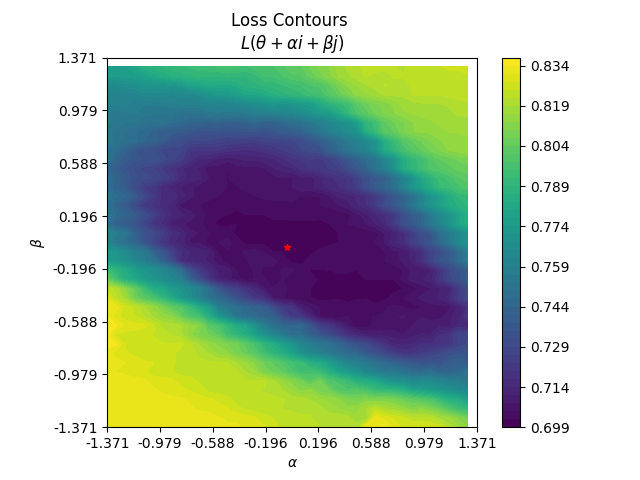

In [46]:
def plot_loss_contours(loss_data, steps, distance, save_fig=False, save_fig_name='loss_contours.png'):
    perturbation_range = np.round(np.linspace(-0.5*distance, 0.5*distance, 8), 3)

    save_fig_name = os.path.join(save_fig_name)
    fig, ax = plt.subplots(1, 1)
    plt.contourf(np.log(loss_data), levels=50)
    ax.set_title('Loss Contours \n'+ r'$L(\theta + \alpha i + \beta j$)')
    ax.axis('square')
    ax.scatter((steps-1)/2., (steps-1)/2., 20, 'r', '*')
    ax.set_xticks(np.linspace(0, steps, 8, endpoint=True))
    ax.set_xticklabels(perturbation_range)
    ax.set_yticks(np.linspace(0, steps, 8, endpoint=True))
    ax.set_yticklabels(perturbation_range)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    plt.colorbar()
    plt.show()

    if save_fig:
        fig.savefig(save_fig_name, transparent=True, dpi=300)

plot_loss_contours(loss_data=loss_data_fin, steps=STEPS, distance=DISTANCE, save_fig=True)

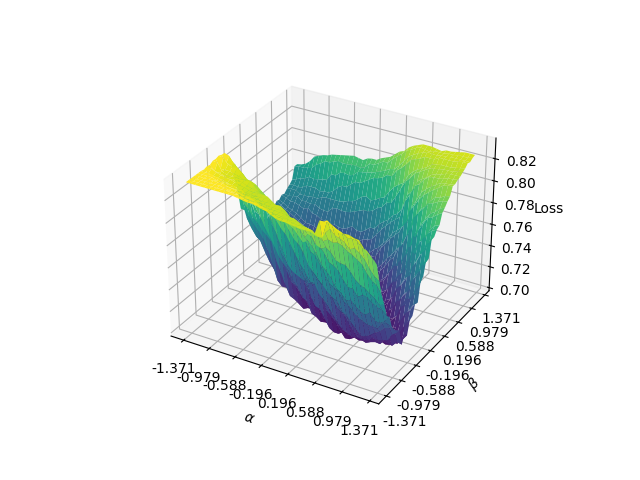

In [47]:
def plot_loss_surface(loss_data, steps, distance, save_fig=False, save_fig_name='loss_surface.png'):
    perturbation_range = np.round(np.linspace(-0.5*distance, 0.5*distance, 8), 3)

    save_fig_name = os.path.join(save_fig_name)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
    Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
    ax.plot_surface(X, Y, np.log(loss_data_fin), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xticks(np.linspace(0, STEPS, 8, endpoint=True))
    ax.set_xticklabels(perturbation_range)
    ax.set_yticks(np.linspace(0, STEPS, 8, endpoint=True))
    ax.set_yticklabels(perturbation_range)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel('Loss')
    plt.show()

    if save_fig:
        fig.savefig(save_fig_name, transparent=True, dpi=300)

plot_loss_surface(loss_data=loss_data_fin, steps=STEPS, distance=DISTANCE, save_fig=True)

# Initial Model

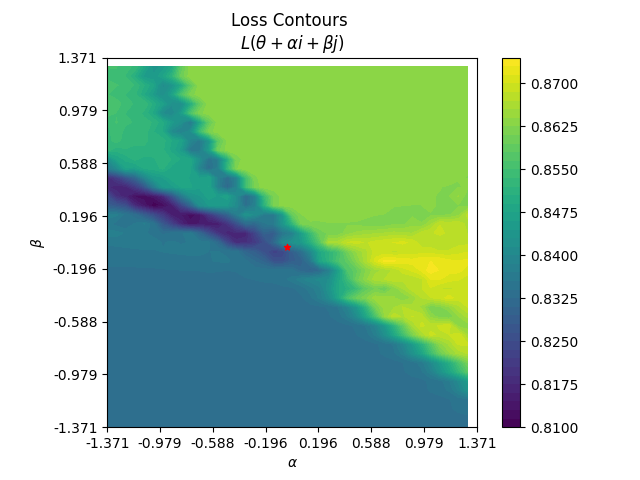

In [41]:
loss_data_initial = loss_landscapes.random_plane(model_initial, metric, distance=DISTANCE, steps=STEPS, normalization='filter', deepcopy_model=True)

plot_loss_contours(loss_data=loss_data_initial, steps=STEPS, distance=DISTANCE)